## ОПИСАНИЕ ПРОЕКТА

Заказчик - стартап, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи их мобильного приложения. 

Изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, мы можем быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

### Описание данных

Каждая запись в логе — это действие пользователя, или событие. 
- __EventName__ — название события;
- __DeviceIDHash__ — уникальный идентификатор пользователя;
- __EventTimestamp__ — время события;
- __ExpId__ — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


__План работы:__
- загрузка необходимых библиотек
- загрузка данных 
- предобработка данных
- определим основные параметры исследования: количество пользователей, период проведения, распределение пользователей по группам
- строим воронку продаж
- сравним группу А-246 и группу А-247, выясним есть ли между ними статистически значимая разница 
- сравним группы А-246/В и А-247/В
- сравним объединенную группу А (А-246 и А-247) и группой В
- выводы

## Проведем предварительную обработку данных:

In [1]:
# импортируем библиотеки
import os
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats as st
import math as mth
import plotly.express as px

In [2]:
# загружаем датасет с данными
pth_1 = '/datasets/logs_exp.csv'
pth_2 = 'logs_exp.csv'
if os.path.exists(pth_1):
    logs = pd.read_csv(pth_1, sep='\t')
elif os.path.exists(pth_2):
    logs = pd.read_csv(pth_2, sep='\t')
else:
    print('Something is wrong')

In [3]:
# Добавим столбцы с датой и с датой/временем
logs['date_time'] = logs['EventTimestamp'].map(lambda x: pd.to_datetime(x, unit='s'))
logs['date'] = logs['date_time'].map(lambda x: x.date())

In [4]:
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [5]:
# Посмотрим информацию о датасете
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   EventName       244126 non-null  object        
 1   DeviceIDHash    244126 non-null  int64         
 2   EventTimestamp  244126 non-null  int64         
 3   ExpId           244126 non-null  int64         
 4   date_time       244126 non-null  datetime64[ns]
 5   date            244126 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 11.2+ MB


Итак, у нас есть датасет на 244126 записей. Непривычные названия столбцов переименуем на привычные: сделаем строчные названия и нижнее подчеркивание. Заменим у столбца "date" тип. Проверим пропуски и дубликаты. Приступим. 

In [6]:
logs = logs.rename(columns={'EventName': 'event_name','DeviceIDHash':'user_id', 'EventTimestamp':'event_timestamp', 'ExpId':'group'})
logs.head()

,event_name,user_id,event_timestamp,group,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [7]:
# Считаем количество пропусков в датасете. 
logs.isna().sum()

event_name         0
user_id            0
event_timestamp    0
group              0
date_time          0
date               0
dtype: int64

In [8]:
# Ищем дубликаты.
logs.duplicated().sum()

413

In [9]:
# Удалим дубликаты, сбросим индексы
logs = logs.drop_duplicates().reset_index(drop=True)

In [10]:
logs

,event_name,user_id,event_timestamp,group,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
243709,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
243710,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
243711,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


In [11]:
logs['date'] = pd.to_datetime(logs['date'])
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   user_id          243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   group            243713 non-null  int64         
 4   date_time        243713 non-null  datetime64[ns]
 5   date             243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


В ходе предобработки обнаружились 413 дубликатов и были удалены методом .drop_duplicates(), индексы упорядочены заново. Всего записей в таблице осталось 243713. Также мы переименовали столбцы, тип данных столбца с датой преобразован в тип datetime64. Приступим к исследованию данных.

# Изучим данные

### Проверим, сколько  и какие события есть:

In [12]:
print('Всего событий:',logs['event_name'].count())
print()
print('Из них уникальных:', logs['event_name'].nunique())
print()
print('Уникальные события:', logs['event_name'].unique())

Всего событий: 243713

Из них уникальных: 5

Уникальные события: ['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']


Эта информация пригодится нам для построения воронки продаж.

### Сколько всего пользователей участвовало в тестах:

In [13]:
#Считаем уникальных пользователей
unique_users = logs['user_id'].nunique()
print('Количество уникальных пользователей:', unique_users)

Количество уникальных пользователей: 7551


__Итого:__ 7551 пользователей. 

### Среднее количество событий на пользователя:

In [14]:
round(logs['event_name'].count()/unique_users)

32

В среднем на одного пользователя приходится 32 события

### Посмотрим, как распределены события по пользователям

In [15]:
logs_grouped = logs.groupby('user_id').agg({'event_timestamp':'count'}).sort_values(by='event_timestamp', ascending=False)


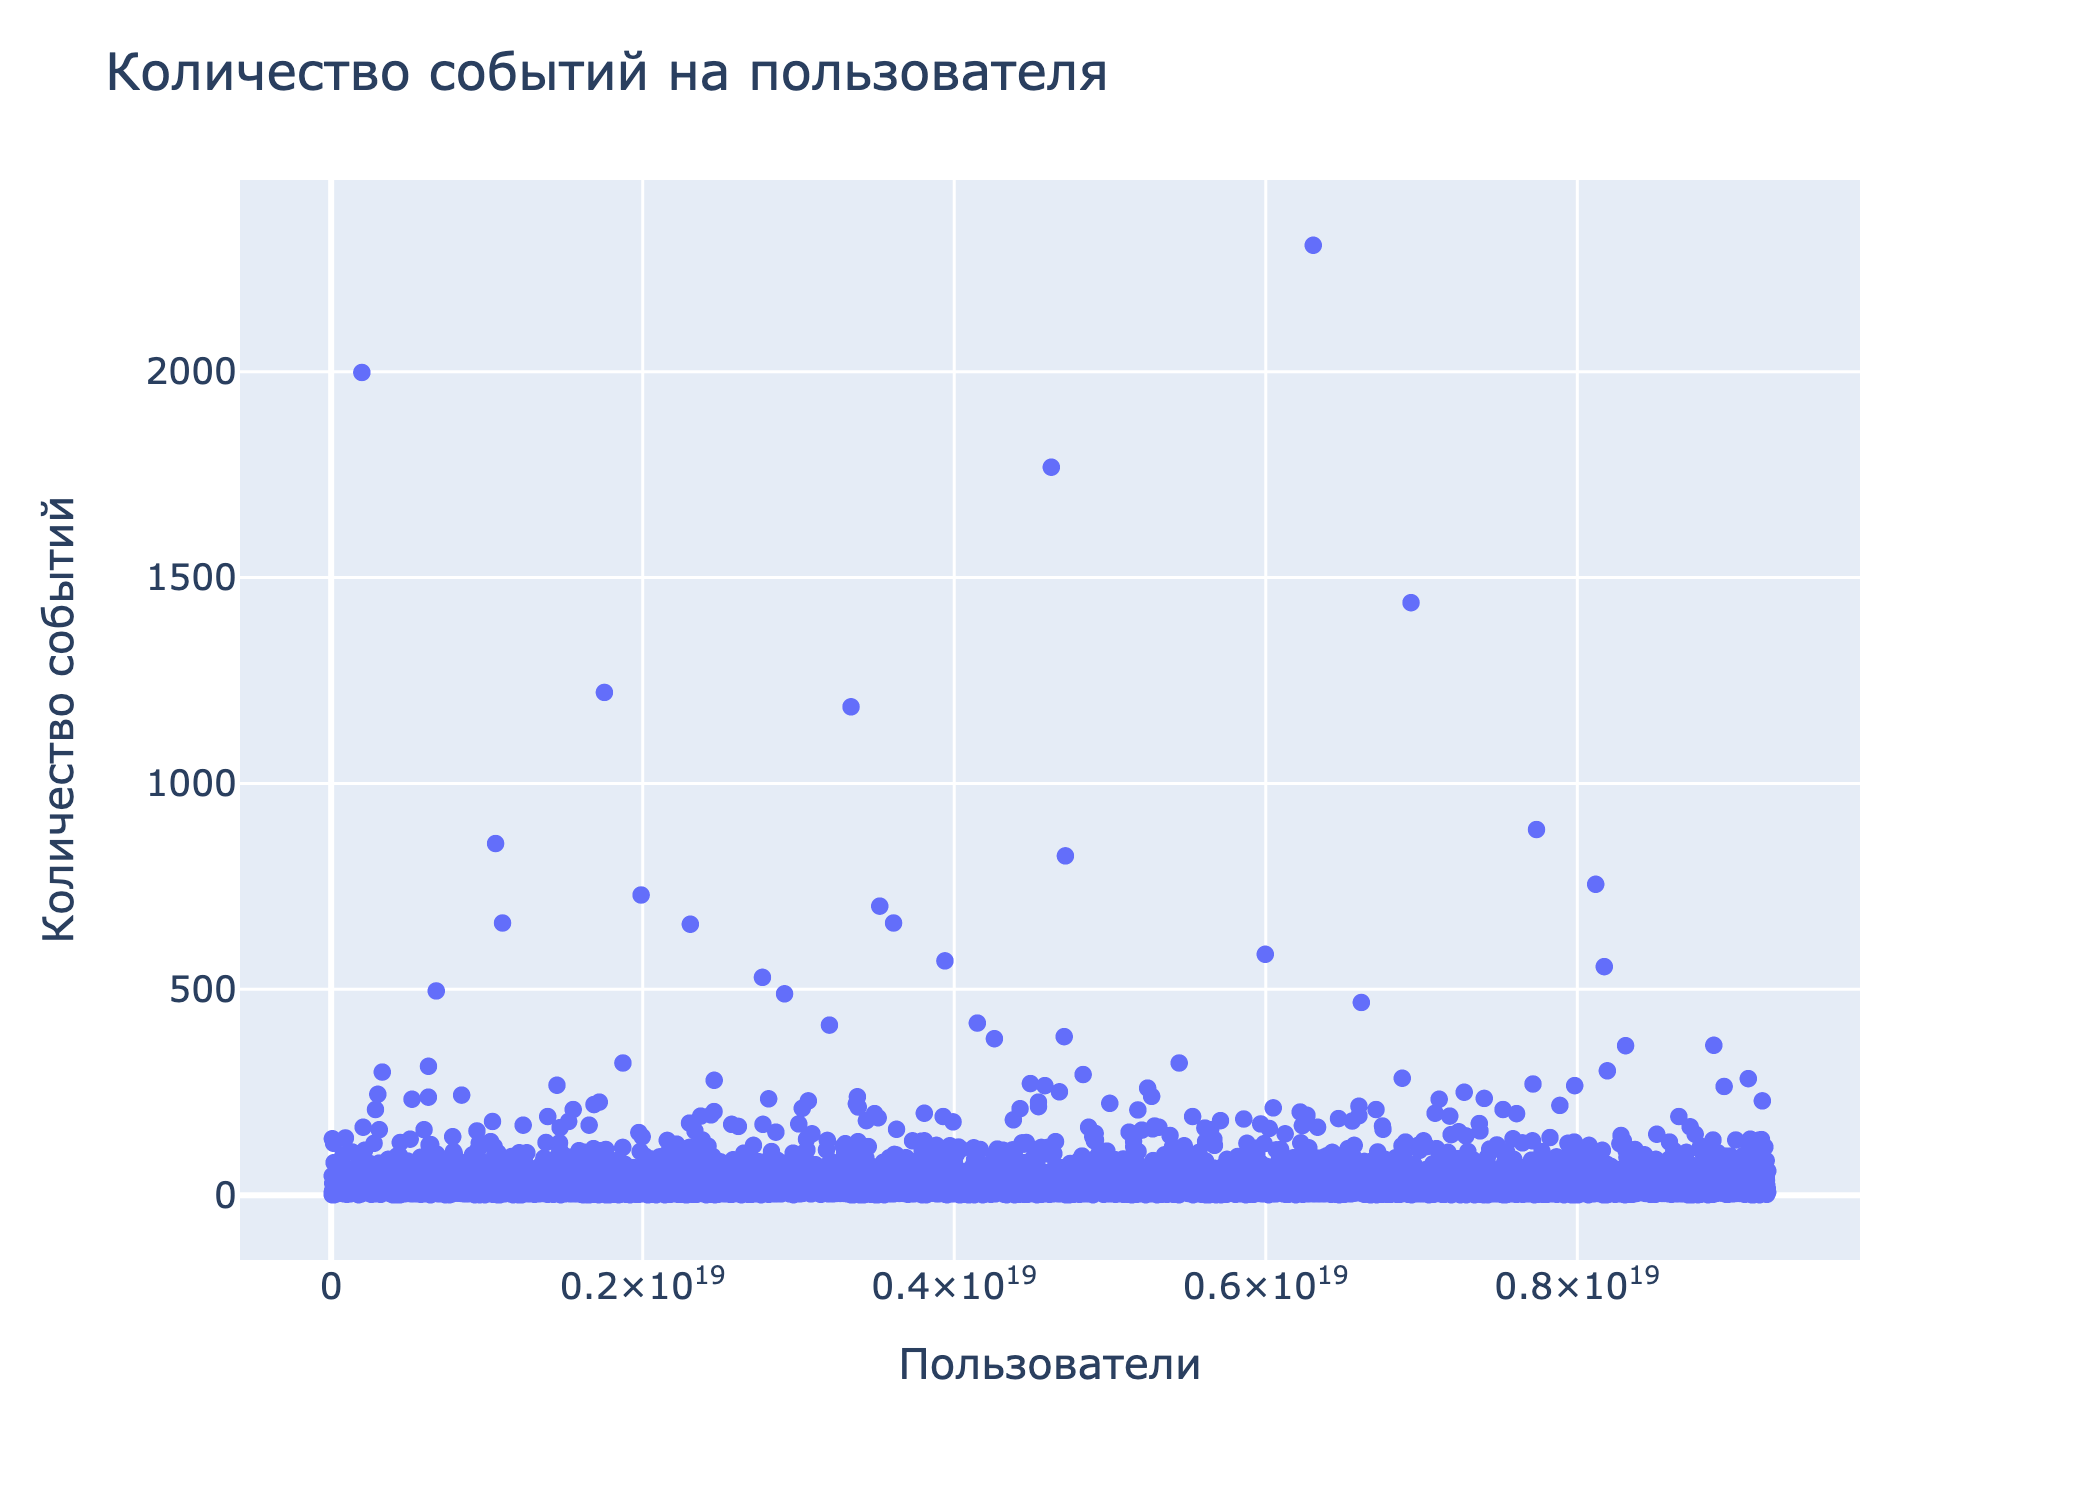

In [16]:
fig = px.scatter(logs_grouped.reset_index(), x = 'user_id', y = "event_timestamp", 
                 labels = dict(user_id = "Пользователи", event_timestamp = "Количество событий"))
fig.update_layout(title = "Количество событий на пользователя")
fig.show(renderer='png', scale=3)

У большинства пользователей количество событий находится в диапазоне от 0 до 200. От 200 до 500 - редскость. Все что выше 500 можно отнести к аномалиям и выбросам. При анализе результатов А/А/В-теста будем использовать непараметрические критерии, дабы выбросы и аномалии не оказали влияния на результаты. 

### Определим,  период проведения эксперимента:

In [17]:
print('Минимальная дата:', logs['date'].min())
print()
print('Макисмальная дата', logs['date'].max())

Минимальная дата: 2019-07-25 00:00:00

Макисмальная дата 2019-08-07 00:00:00


Построим гистограмму по дате-времени, чтобы убедиться, что данные полные за весь период эксперимента. 

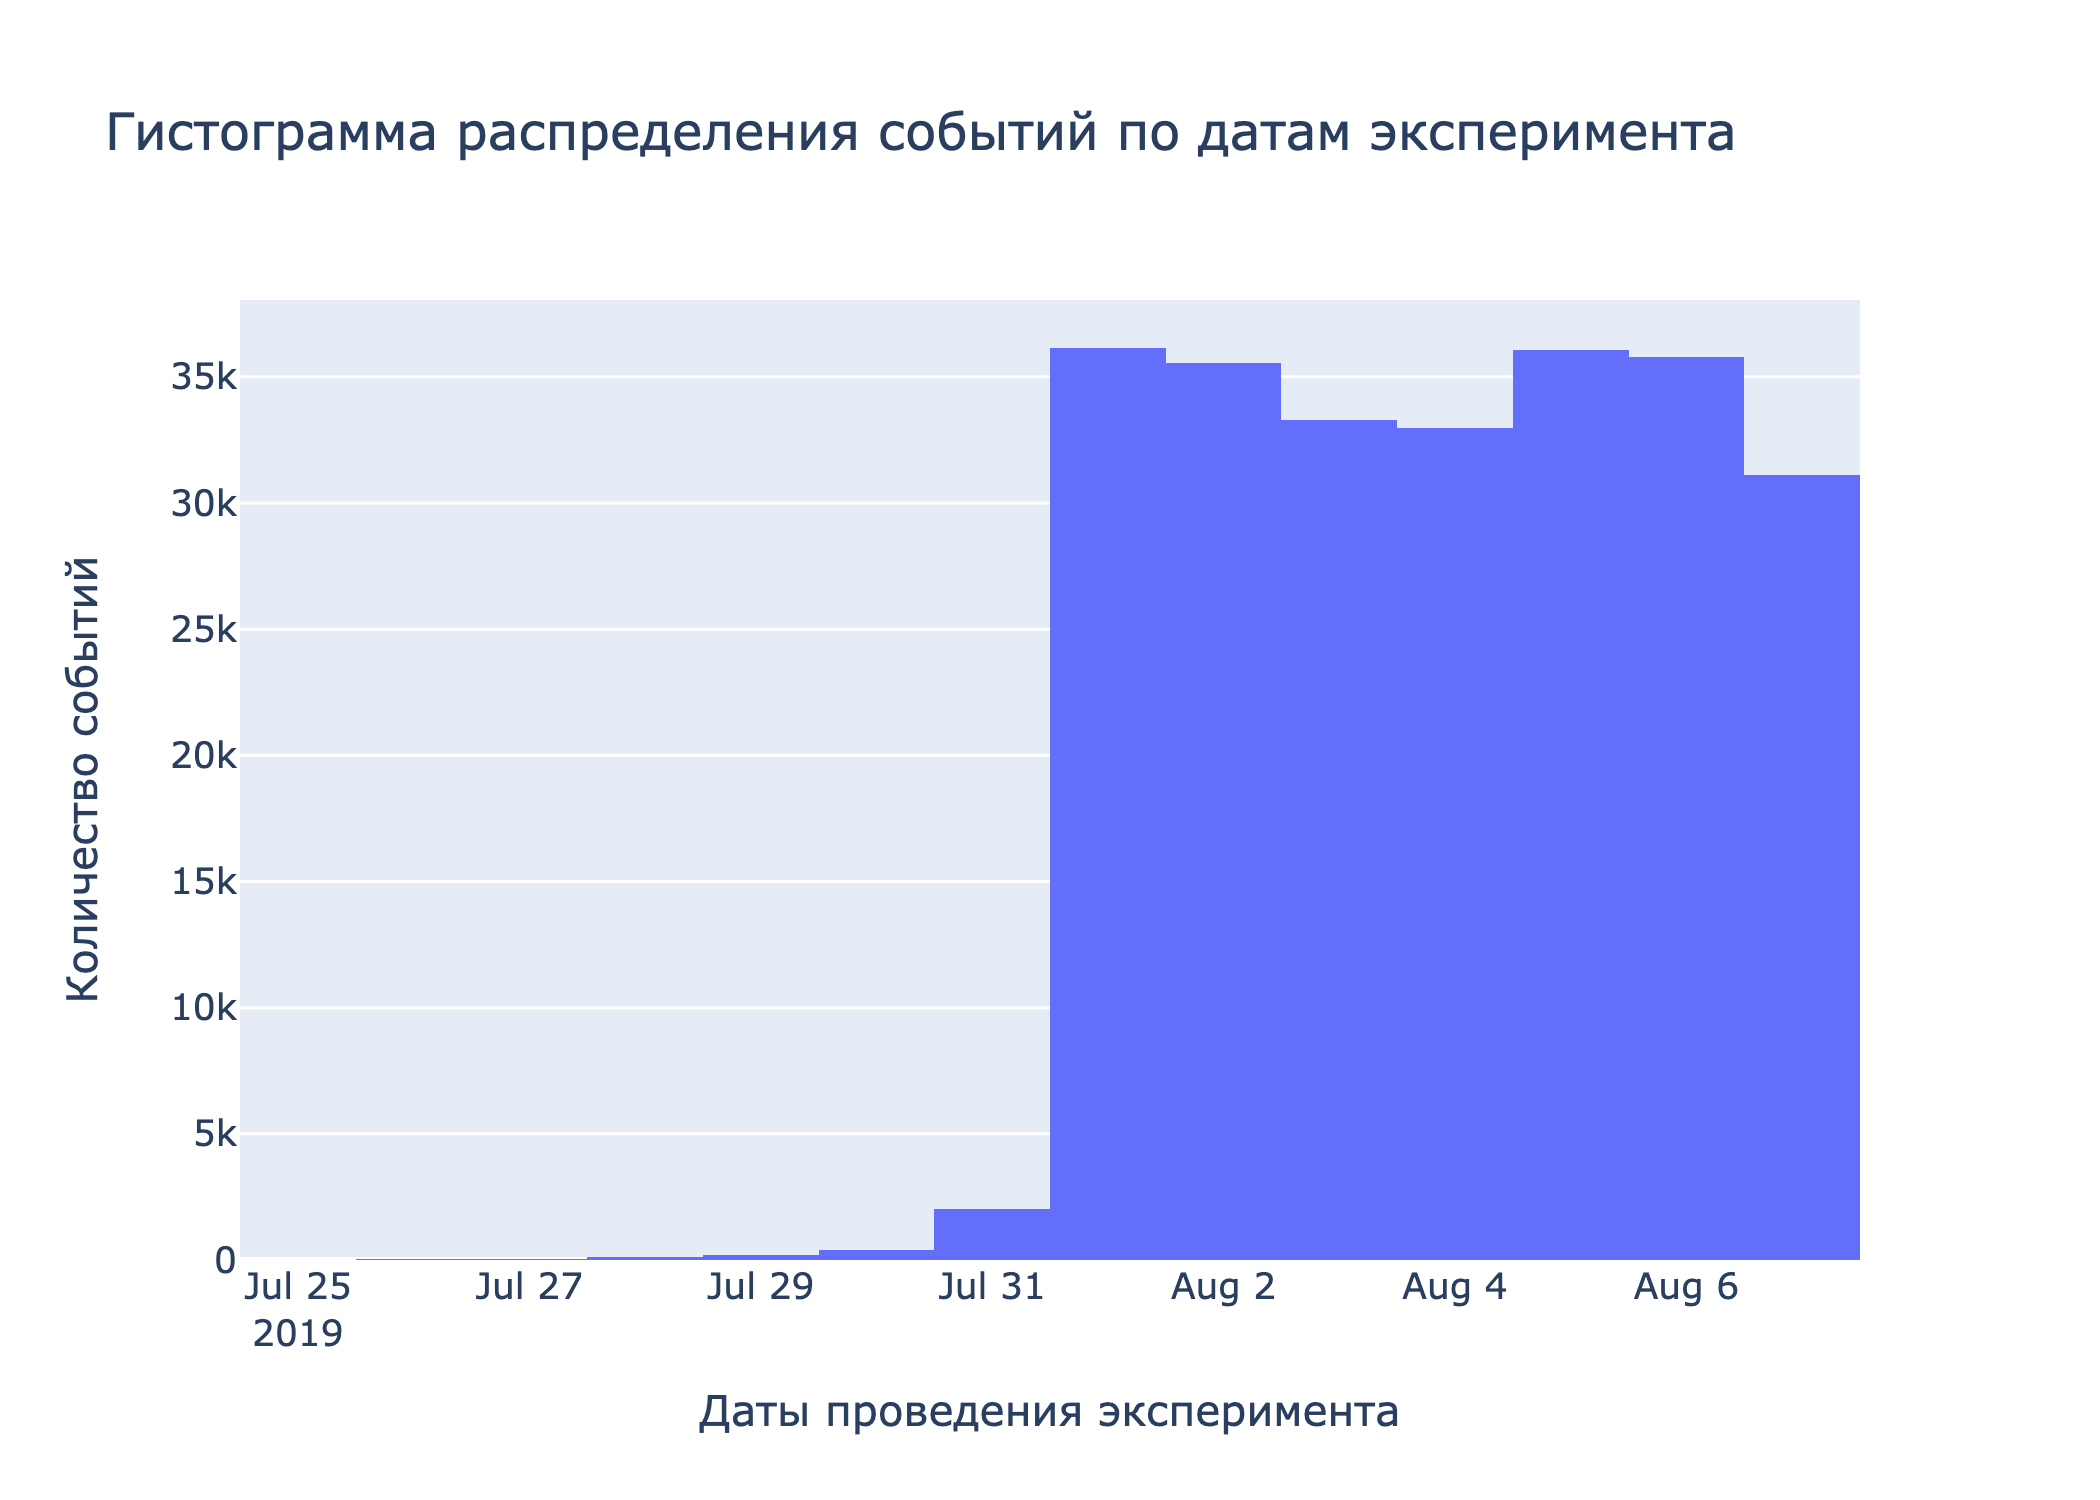

In [18]:
fig = px.histogram(logs, x="date", labels=dict(date="Даты проведения эксперимента", count="Количество событий"), 
                  title='Гистограмма распределения событий по датам эксперимента')
fig.update_yaxes(title='Количество событий')
fig.show(renderer='png', scale=3)

Как показала гистограмма, из двух недель эксперимента, мы имеем полные данные только с 1 по 7 августа. Отфильтруем датасет по датам, посчитаем уникальных пользователей еще раз.

In [19]:
print('Количество уникальных пользователей до проверки:', unique_users)
print('Количество событий до проверки:', logs['event_name'].count())
print()
events_count =  logs['event_name'].count()
logs = logs.query('date >="2019-08-01"')
unique_users_2 = logs['user_id'].nunique()
events_count_after =  logs['event_name'].count()
print('Количество уникальных пользователей после проверки:', unique_users_2)
print('% уменьшения количества пользователей к первоначальному количеству', (unique_users - unique_users_2)/(unique_users/100))
print()
print('Количество событий после проверки:', logs['event_name'].count())
print('% уменьшения количества событий к первоначальному', (events_count - events_count_after)/(events_count/100))


Количество уникальных пользователей до проверки: 7551
Количество событий до проверки: 243713

Количество уникальных пользователей после проверки: 7534
% уменьшения количества пользователей к первоначальному количеству 0.22513574361011784

Количество событий после проверки: 240887
% уменьшения количества событий к первоначальному 1.159560630741897


Таким образом мы отбросили 0,22% пользователей и 1,15% событий. 

### Распеределение пользователей по группам

In [20]:
# Посмотрим, как распределяются пользователи по группам: 
users_distribution = logs.groupby('group').agg({'user_id':'nunique'}).reset_index()
# % пользователей в группе
users_distribution['ratio_to_total'] = ((users_distribution['user_id'] / unique_users)*100).round(2)
# Всего пользователей участвовавших в исследовании
users_distribution['total'] = users_distribution['user_id'].sum()
users_distribution

,group,user_id,ratio_to_total,total
0,246,2484,32.90,7534
1,247,2513,33.28,7534
2,248,2537,33.60,7534


__Около ~2500 пользователей на группу, в относительном измерении - по ~33% пользователей на группу__

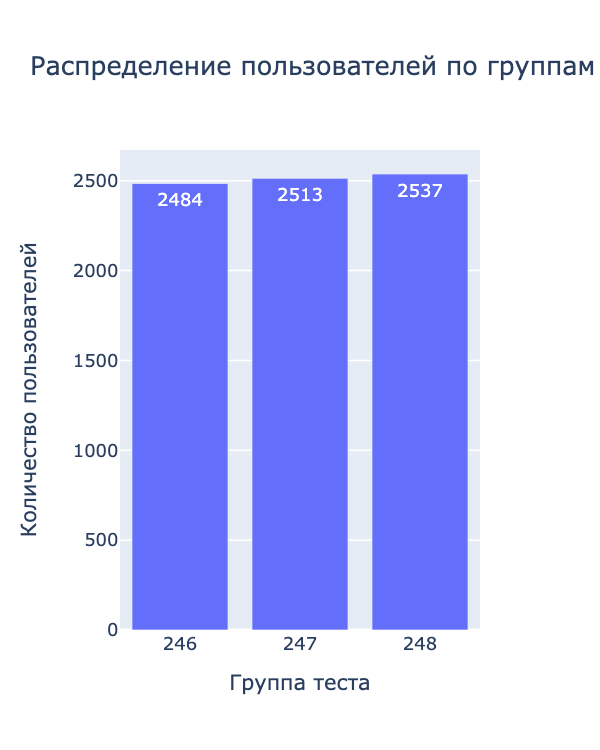

In [21]:
fig = px.bar(users_distribution, x='group', y='user_id', title='Распределение пользователей по группам теста',
            width = 400, labels={"group": "Группа теста",  "user_id": "Количество пользователей"}, text_auto = True)
fig.show(renderer='png', scale=1.5)

Распределение пользователей между группами теста вполне равномерное. Разброс около 1%. А значит процесс деления трафика работает корректно. 

# Изучим воронку событий 

### Посмотрим, какие события есть в логах, как часто они встречаются.

In [22]:
logs.groupby(['event_name']).agg({'event_timestamp':'count'}).sort_values('event_timestamp', ascending = False)


,event_timestamp
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


Похоже на воронку.  Больше всего событий в верхней строке, меньше всего  в нижней.

### Рассчитаем количество пользователей в каждом событии. 

In [23]:
funnel= logs.groupby(['event_name']).agg({'user_id':'nunique'}).sort_values('user_id', ascending = False).reset_index()
# количество пользователей, совершивших >=1 события
users_cr = funnel.loc[0, 'user_id'] 
# % пользователей перешедших на следующий этап к пользователям, совершившим >=1 событие  
funnel['users_ratio'] = ((funnel['user_id'] / users_cr)*100).round(2) 
# переименуем столбцы
funnel.columns=['event_name','users_count','CR']
funnel

,event_name,users_count,CR
0,MainScreenAppear,7419,100.00
1,OffersScreenAppear,4593,61.91
2,CartScreenAppear,3734,50.33
3,PaymentScreenSuccessful,3539,47.70
4,Tutorial,840,11.32


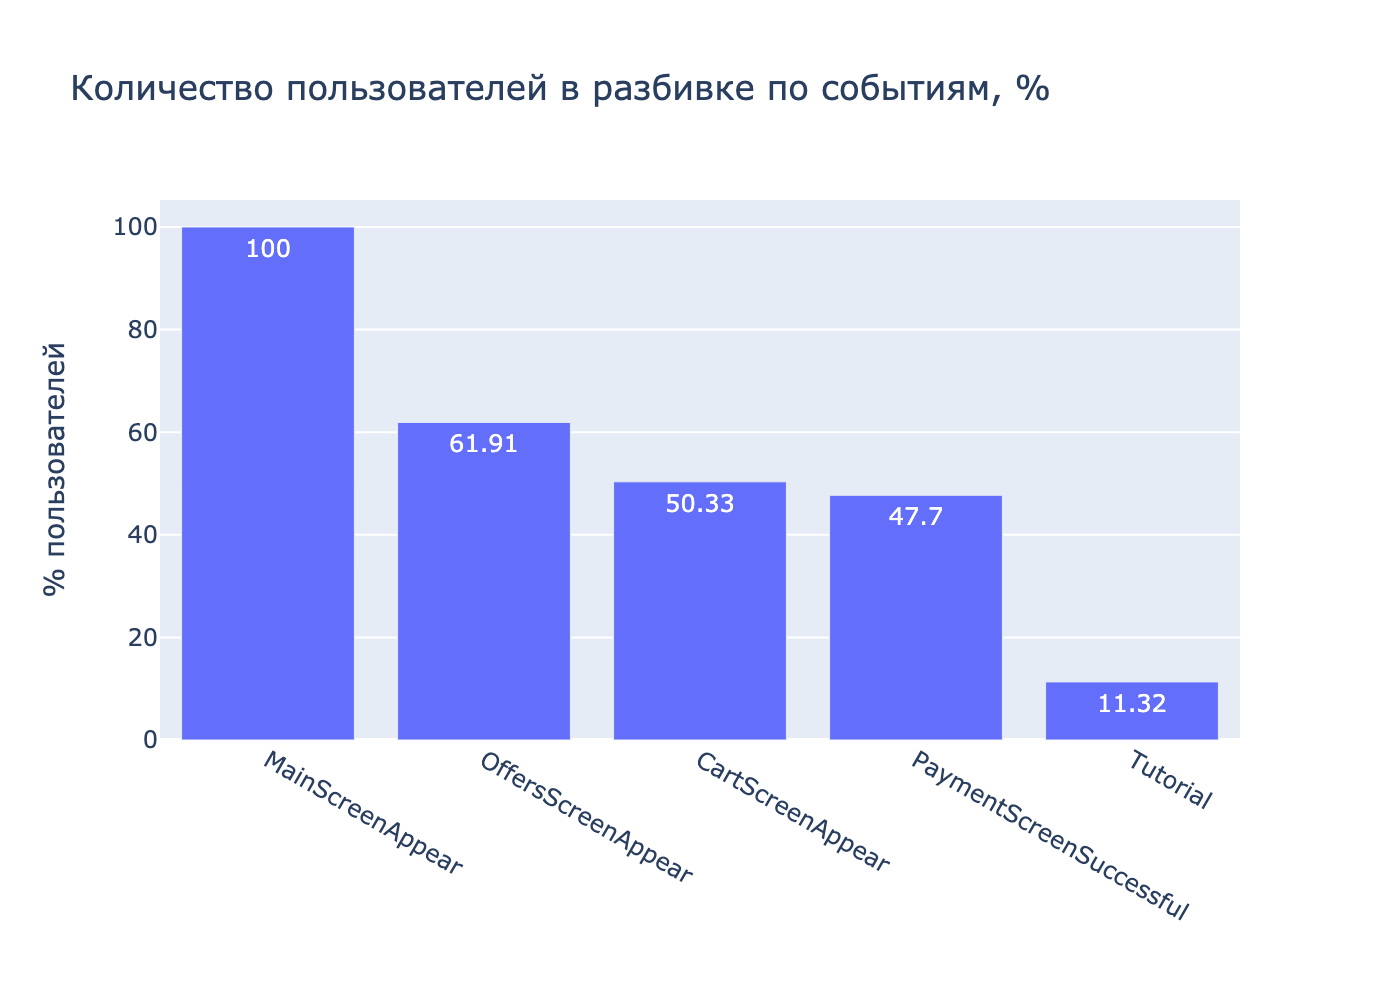

In [24]:
# построим график для наглядности
fig = px.bar(funnel, x='event_name', y='CR',
             labels={'event_name':'', 'CR':'% пользователей'}, 
             title='Количество пользователей в разбивке по событиям, %',
             text_auto=True)
fig.show(renderer='png', scale=2)

Итак, очевидно что перед нами воронка событий, примечательно что на двух ее этапах есть резкое падение количества пользователей. Предположим порядок событий исходя из нашей воронки: 

1) отображение главного экрана - MainScreenAppear, 

2) отображение экрана с продуктами - OffersScreenAppear,

3) отображение экрана корзины - CartScreenAppear,

4) отображение экрана успешной оплаты заказа - PaymentScreenSuccessful, 

5) инструкция - Tutorial. 

Теперь стало понятным сильное падение графика между пунктом 4 и 5 - не все пользователи смотрят инструкции, так как большинство приложений делаются интуитивно-понятными. Пятый пункт стоит исключить из расчета воронки.

### Рассчитаем, долю пользователей проходящих на следующий этап воронки. 

In [25]:
# фильтруем данные, убираем из воронки этап с инструкцией
funnel_filtered = funnel.query('event_name!="Tutorial"')

In [51]:
# рассчитываем конверсию
for i in range(len(funnel_filtered)-1):
    
    funnel_filtered.loc[(i+1),'CR_to_step'] = ((funnel_filtered.loc[(i+1),'users_count'] / funnel_filtered.loc[i,'users_count'])*100).round()
funnel_filtered    

,event_name,users_count,CR,CR_to_step
0,MainScreenAppear,7419,100.00,NaN
1,OffersScreenAppear,4593,61.91,62.0
2,CartScreenAppear,3734,50.33,81.0
3,PaymentScreenSuccessful,3539,47.70,95.0


Большой разрыв конверсии между первым и вторым шагами - практически 60%. До оплаты доходит 47,7% пользователей. Построим воронку:

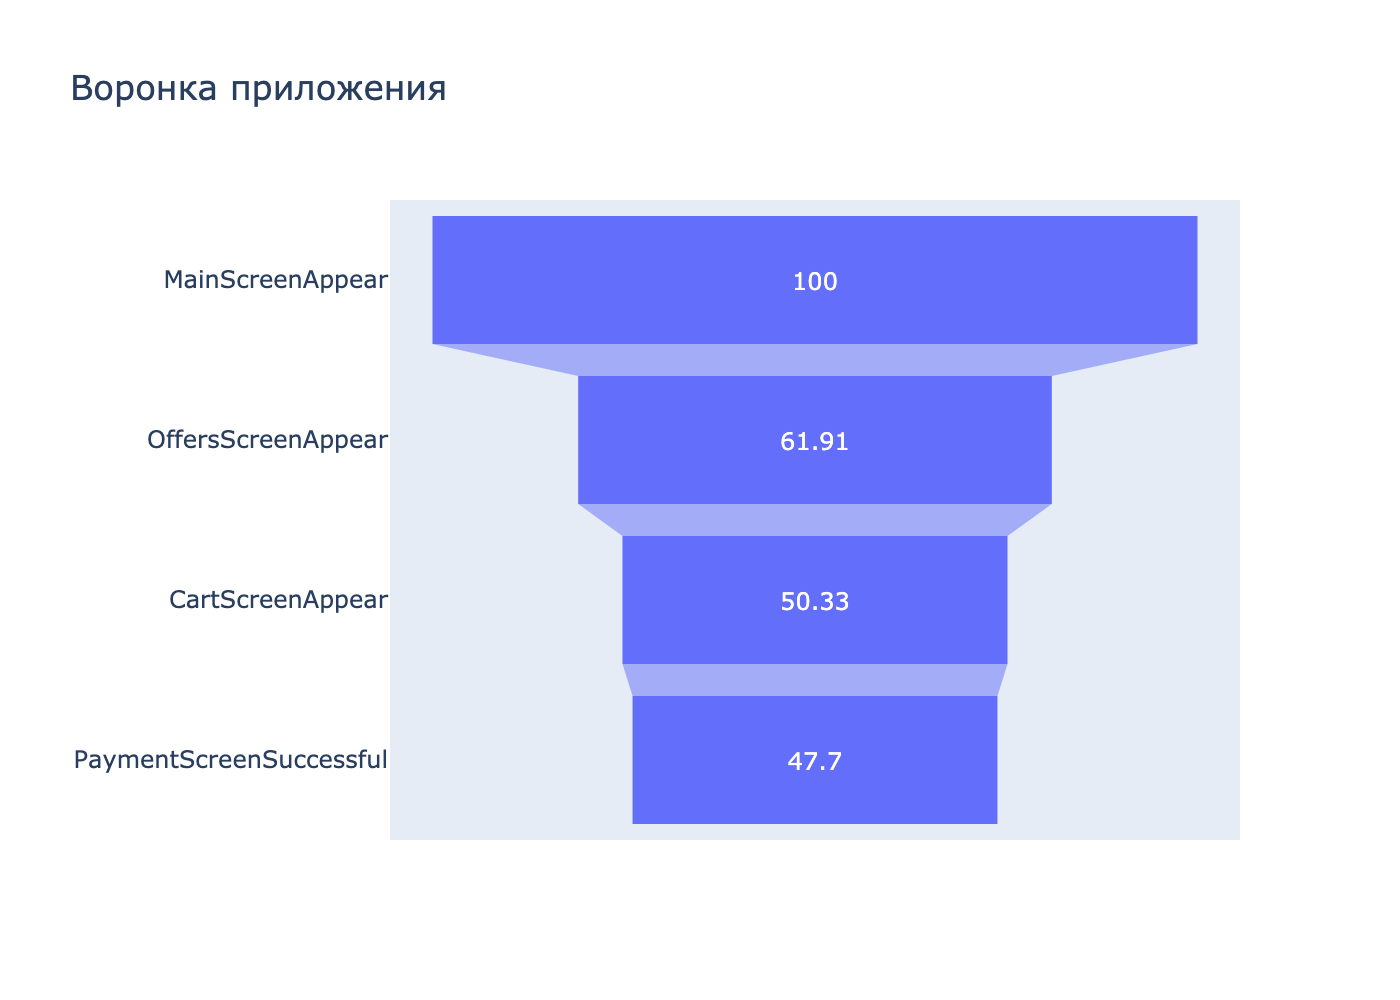

In [27]:
fig = px.funnel(funnel_filtered, x='CR', y='event_name', title='Воронка приложения',
             labels={'event_name':'', 'CR':''})

fig.show(renderer='png', scale=2)

__Разница между первым этапом воронки и вторым составила 38%. Далее идет плавное снижение числа пользователей (12%). А между просмотром корзины и оплатой разница всего в 3%__

# Изучим результаты тестирования А/А/В

In [28]:
# Распределение пользователей по группам
users_distribution

,group,user_id,ratio_to_total,total
0,246,2484,32.90,7534
1,247,2513,33.28,7534
2,248,2537,33.60,7534


Проверим возможные пересечения пользователей в группах. 

In [29]:
# Проверим пользователей, которые могли участвовать в двух или нескольких группах одновременно:
logs.groupby('user_id').agg({'group':'nunique'}).query('group > 1') 

,group
user_id,


Пересечения не обнаружены. Продолжаем анализ. 

### Создадим выборки и проверим их тестом Уилкоксона-Манна-Уитни
Так как у нас три части (доли) идут в сравнение, то используем z-критерий для проверки статистически значимой разницы. 

Подготовим данные для проверки z-критерия. 

In [30]:
df = users_distribution.query('group!=248')

Проверим корректность разделения трафика на группы. Если статистически значимой разницы между группами А и А не будет, можем считать, что трафик разделен корректно на все три группы А, А и В. 

In [31]:
# Проверим доли А-246 и А-247 на равество долей: 

alpha = 0.05  # критический уровень статистической значимости

a1=df.loc[0,'user_id']
a2=df.loc[1,'user_id']
s1=df.loc[0,'total']
s2=df.loc[1,'total']
#p = np.array([2484, 2513])
#l = np.array([7534, 7534])

p1 = a1 / s1
p2 = a2 / s2
p_combined = (a1+a2)/(s1+s2)
difference = p1-p2
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/s1 + 1/s2))
distr = st.norm(0,1)


p_value = (1-distr.cdf(abs(z_value)))*2

print('p-значение: ', p_value)

if p_value<alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.615804820320411
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


__Проверка долей z-критерием показала, что различний между группой А-246 и А-247 нет. Можно сказать, что разбиение на группы работает корректно.__

### Выберем самое популярное событие

In [32]:
# Создадим сводную таблицу по названиям событий, посчитаем количество временных меток
most_popular_event = logs.pivot_table(index='event_name',columns='group',values='event_timestamp',aggfunc='count').sort_values(246, ascending = False)
most_popular_event.reset_index()


group,event_name,246,247,248
0,MainScreenAppear,37676,39090,40562
1,OffersScreenAppear,14767,15179,16387
2,CartScreenAppear,14690,12434,15179
3,PaymentScreenSuccessful,11852,9981,12085
4,Tutorial,317,338,350


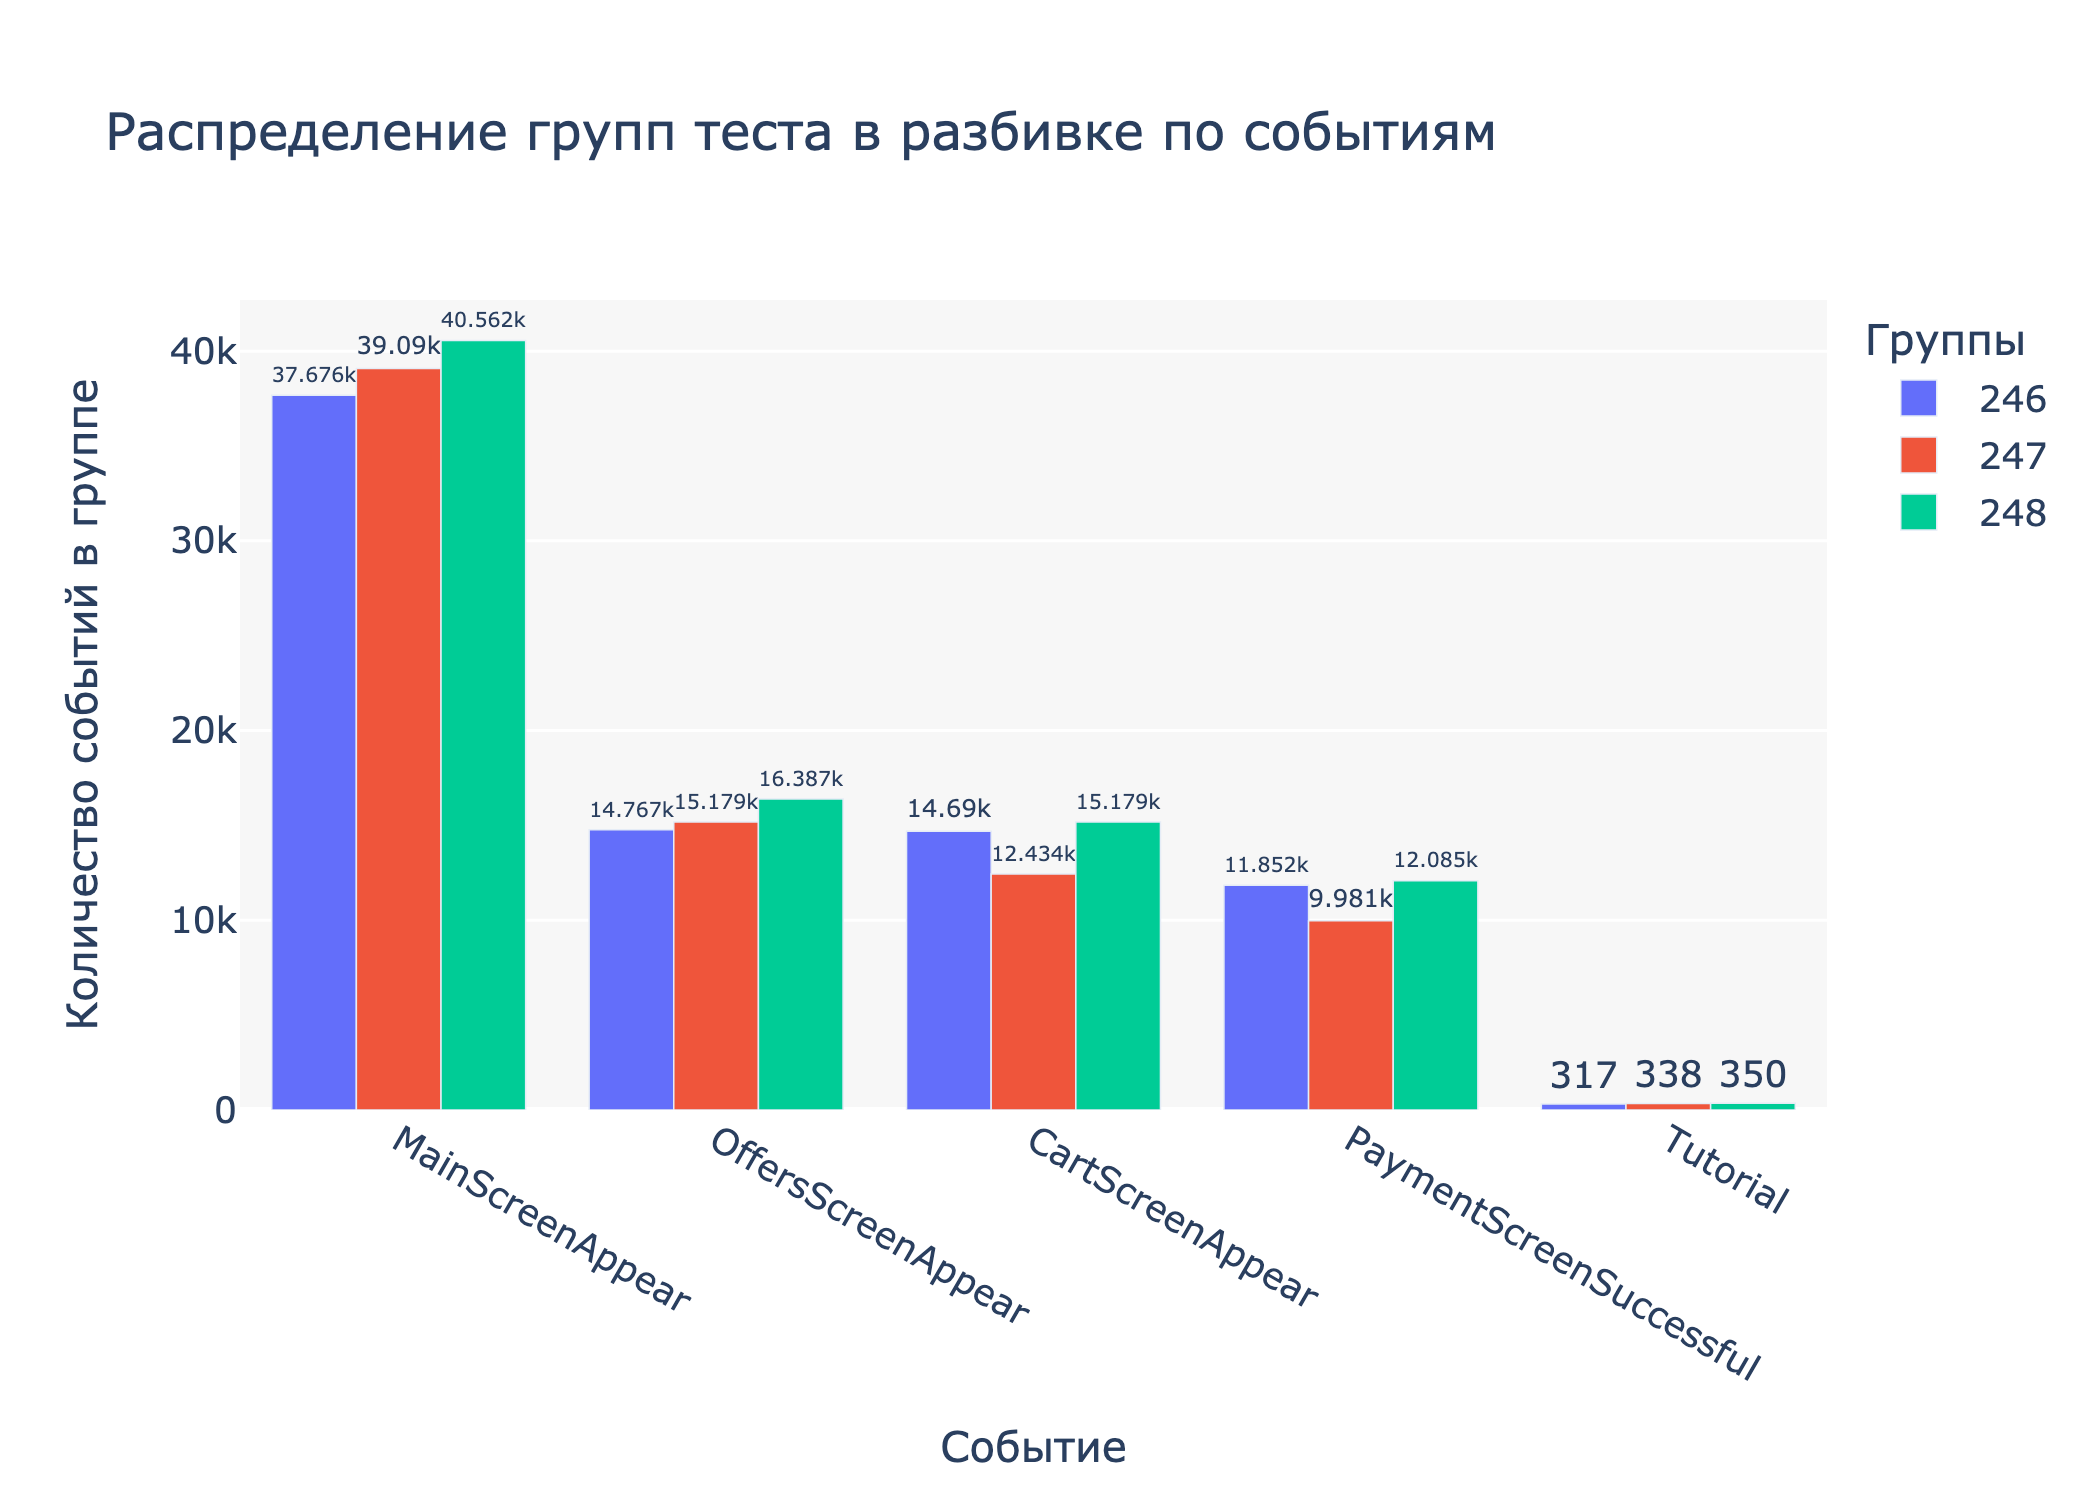

In [33]:
fig = px.bar(most_popular_event.reset_index(), x="event_name", 
              y=[246,247,248], barmode='group', title='Распределение групп теста в разбивке по событиям',
            text_auto=True)
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=True)
fig.update_layout(plot_bgcolor='#F7F7F7', 
                 xaxis_title='Событие',
                 yaxis_title='Количество событий в группе',
                 legend_title_text='Группы')
fig.show(renderer='png', scale=3)

Самым популярным событием во всех трех группах теста является показ главного экрана - __MainScreenAppear__. Разница между группами 246 и 247 группами 1,42тыс. Между 246 и 248 группой 2,89тыс, между группой 247 и 248 - 1,47 тыс.

### Рассчитаем количество и долю пользователей, совершивших событие MainScreenAppear в каждой из групп

In [34]:
users_per_events =logs.query('event_name=="MainScreenAppear"').groupby('group').agg({'user_id':'nunique'})
users_per_events['total_users'] = users_per_events['user_id'].sum()
users_per_events['ratio_users_to_events'] = ((users_per_events['user_id'] / users_per_events['total_users'])*100).round(2)
users_per_events.columns = ['users_count','total_users','ratio']
users_per_events = users_per_events.reset_index().set_index('group')
users_per_events

,users_count,total_users,ratio
group,,,
246,2450,7419,33.02
247,2476,7419,33.37
248,2493,7419,33.60


Разница между количеством пользователей не достигает и 1%. 

## Проведем проверку различий долей в группе А/А отдельно на каждом этапе воронки.

__Для расчетов различий долей снова используем z-критерий. Создадим функцию, передадим ей в качестве аргументов датасет и номера исследуемых групп. Функция проверит различия на каждом этапе воронки и вернет 4 результата__

Нулевая гипотеза: статистически значимых различий долей в группе А и А на данном эатпе теста нет. Альтернативная гипотеза - статистически значимые различия есть. 

In [35]:
def z_test(df, group_1, group_2):
    alpha = 0.05  # критический уровень статистической значимости
    # этапы воронки
    steps = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
    #количество пользователей в группе
    users_per_groups = logs.groupby('group').agg({'user_id':'nunique'})
    s1 = users_per_groups.loc[group_1,'user_id']
    s2 = users_per_groups.loc[group_2,'user_id']
    #запускаем цикл по этапам воронки
    for step in steps:
        #фильруем датасет по группам и этапам и получаем данные:
        a1 = df[(df.index==group_1) & (df['event_name']==step)]['user_id']
        a1 = a1[group_1]
        a2 = df[(df.index==group_2) & (df['event_name']==step)]['user_id']
        a2 = a2[group_2]
        # рассчитываем z-критерий
        p1 = a1 / s1
        p2 = a2 / s2
        p_combined = (a1+a2)/(s1+s2)
        difference = p1-p2
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/s1 + 1/s2))
        distr = st.norm(0,1)
        p_value = (1-distr.cdf(abs(z_value)))*2

        #print('p-значение: ', p_value)
        print(f'На этапе {step} р-значение составило: {p_value}')
        
        if p_value<alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
            print()
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
            print()
            

In [36]:
# Создадим датасет для передачи в функцию:  
df = logs.query('event_name!="Tutorial"').groupby(['group','event_name']).agg({'user_id':'nunique'}).reset_index().set_index('group')
df

,event_name,user_id
group,,
246,CartScreenAppear,1266
246,MainScreenAppear,2450
246,OffersScreenAppear,1542
246,PaymentScreenSuccessful,1200
247,CartScreenAppear,1238
247,MainScreenAppear,2476
247,OffersScreenAppear,1520
247,PaymentScreenSuccessful,1158
248,CartScreenAppear,1230


In [37]:
# Проверим различие долей групп А/А
z_test(df, 246, 247)

На этапе MainScreenAppear р-значение составило: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

На этапе OffersScreenAppear р-значение составило: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

На этапе CartScreenAppear р-значение составило: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

На этапе PaymentScreenSuccessful р-значение составило: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



### Общий вывод проверки результатов теста группы А/А: 
Между группами А и А (246 и 247) нет статистически значимых различий. Разбиение на группы работает корректно. 

## Сравним группы А246/В и А247/В

Нулевая гипотеза: статистически значимых различий долей в группе А и В на данном этапе теста нет. Альтернативная гипотеза - статистически значимые различия есть. 

__Начнем сравнение 246 и 248 групп.__

In [38]:
z_test(df, 246, 248)

На этапе MainScreenAppear р-значение составило: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

На этапе OffersScreenAppear р-значение составило: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

На этапе CartScreenAppear р-значение составило: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

На этапе PaymentScreenSuccessful р-значение составило: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



__Сравним группы 247 и 248__

In [39]:
z_test(df, 247, 248)

На этапе MainScreenAppear р-значение составило: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

На этапе OffersScreenAppear р-значение составило: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

На этапе CartScreenAppear р-значение составило: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

На этапе PaymentScreenSuccessful р-значение составило: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



__По результатам попарного сравнения групп А246/В и А247/В можно сделать вывод, что статистически важных различий между долями нет. Результатом теста можно признать, что изменение шрифта в приолжении не повлияло на поведение пользователей__

### Объединим контрольные группы А246 и А247 в одну и сравним с группой В

In [40]:
# модифицируем датасет df. Объединим группы 246 и 247
df_aa = logs[logs['group']!=248].groupby(['event_name']).agg({'user_id':'nunique'}).reset_index()
df_aa['group']='aa'
df_aa = df_aa.set_index('group')


In [41]:
# отдельно рассчитаем количество пользователей в группе В, для дальнейшего объединения датафреймов
df_b = logs[logs['group']==248].groupby(['event_name']).agg({'user_id':'nunique'}).reset_index()
df_b['group']='b'
df_b = df_b.set_index('group')
# объединим датафреймы в один
df_new = pd.concat([df_aa, df_b], axis =0)
df_new

,event_name,user_id
group,,
aa,CartScreenAppear,2504
aa,MainScreenAppear,4926
aa,OffersScreenAppear,3062
aa,PaymentScreenSuccessful,2358
aa,Tutorial,561
b,CartScreenAppear,1230
b,MainScreenAppear,2493
b,OffersScreenAppear,1531
b,PaymentScreenSuccessful,1181


In [42]:
# Рассчитаем количество пользователей в группе аа
group_aa = logs[logs['group']!=248]['user_id'].nunique()
group_b = logs[logs['group']==248]['user_id'].nunique()


In [43]:
# модифицируем фцнкцию под новое количество участников в группе
def z_test_modified(df, group_1, group_2, group_aa, group_b):
    alpha = 0.05  # критический уровень статистической значимости
    # этапы воронки
    steps = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
    #количество пользователей в группе
    s1 = group_aa
    s2 = group_b
    #запускаем цикл по этапам воронки
    for step in steps:
        #фильруем датасет по группам и этапам и получаем данные:
        a1 = df[(df.index==group_1) & (df['event_name']==step)]['user_id']
        a1 = a1[group_1]
        a2 = df[(df.index==group_2) & (df['event_name']==step)]['user_id']
        a2 = a2[group_2]
        # рассчитываем z-критерий
        p1 = a1 / s1
        p2 = a2 / s2
        p_combined = (a1+a2)/(s1+s2)
        difference = p1-p2
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/s1 + 1/s2))
        distr = st.norm(0,1)
        p_value = (1-distr.cdf(abs(z_value)))*2

        #print('p-значение: ', p_value)
        print(f'На этапе {step} р-значение составило: {p_value}')
        
        if p_value<alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
            print()
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
            print()
            

In [44]:
z_test_modified(df_new, 'aa', 'b', group_aa, group_b)

На этапе MainScreenAppear р-значение составило: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

На этапе OffersScreenAppear р-значение составило: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

На этапе CartScreenAppear р-значение составило: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

На этапе PaymentScreenSuccessful р-значение составило: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



__После объединения групп А246 и А247, и сравнения с группой В снова не получили статистически значимых различий между долями. Теперь можно с уверенностью сказать, что изменение шрифтов не повлияло на пользователей.__

Так как нами были проведены 16 экспериментов, мы увеличили вероятность совершить ошибку первого рода - получить ложнопозитивный результат. Чтобы этого избежать необходимо применять попровки: Бонферрони, Шидака или Холма. Попробую изменить уровень альфа в функции и проверить гипоты еще раз. 

In [45]:
def z_test_rider(df, group_1, group_2):
    # этапы воронки
    steps = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
    alpha = (1 - (1 - 0.05)**(1/len(steps)))
    #количество пользователей в группе
    users_per_groups = logs.groupby('group').agg({'user_id':'nunique'})
    s1 = users_per_groups.loc[group_1,'user_id']
    s2 = users_per_groups.loc[group_2,'user_id']
    #запускаем цикл по этапам воронки
    for step in steps:
        #фильруем датасет по группам и этапам и получаем данные:
        a1 = df[(df.index==group_1) & (df['event_name']==step)]['user_id']
        a1 = a1[group_1]
        a2 = df[(df.index==group_2) & (df['event_name']==step)]['user_id']
        a2 = a2[group_2]
        # рассчитываем z-критерий
        p1 = a1 / s1
        p2 = a2 / s2
        p_combined = (a1+a2)/(s1+s2)
        difference = p1-p2
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/s1 + 1/s2))
        distr = st.norm(0,1)
        p_value = (1-distr.cdf(abs(z_value)))*2

        #print('p-значение: ', p_value)
        print(f'На этапе {step} р-значение составило: {p_value}')
        
        if p_value<alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
            print()
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
            print()
            

In [46]:
z_test_rider(df, 246, 247)

На этапе MainScreenAppear р-значение составило: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

На этапе OffersScreenAppear р-значение составило: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

На этапе CartScreenAppear р-значение составило: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

На этапе PaymentScreenSuccessful р-значение составило: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [47]:
z_test_rider(df, 247, 248)

На этапе MainScreenAppear р-значение составило: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

На этапе OffersScreenAppear р-значение составило: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

На этапе CartScreenAppear р-значение составило: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

На этапе PaymentScreenSuccessful р-значение составило: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [48]:
z_test_rider(df, 247, 248)

На этапе MainScreenAppear р-значение составило: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

На этапе OffersScreenAppear р-значение составило: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

На этапе CartScreenAppear р-значение составило: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

На этапе PaymentScreenSuccessful р-значение составило: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [49]:
# модифицируем фцнкцию под новое количество участников в группе
def z_test_modified(df, group_1, group_2, group_aa, group_b):
    # этапы воронки
    steps = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
    alpha = (1 - (1 - 0.05)**(1/len(steps)))
    #количество пользователей в группе
    s1 = group_aa
    s2 = group_b
    #запускаем цикл по этапам воронки
    for step in steps:
        #фильруем датасет по группам и этапам и получаем данные:
        a1 = df[(df.index==group_1) & (df['event_name']==step)]['user_id']
        a1 = a1[group_1]
        a2 = df[(df.index==group_2) & (df['event_name']==step)]['user_id']
        a2 = a2[group_2]
        # рассчитываем z-критерий
        p1 = a1 / s1
        p2 = a2 / s2
        p_combined = (a1+a2)/(s1+s2)
        difference = p1-p2
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/s1 + 1/s2))
        distr = st.norm(0,1)
        p_value = (1-distr.cdf(abs(z_value)))*2

        #print('p-значение: ', p_value)
        print(f'На этапе {step} р-значение составило: {p_value}')
        
        if p_value<alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
            print()
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
            print()
            

In [50]:
z_test_modified(df_new, 'aa', 'b', group_aa, group_b)

На этапе MainScreenAppear р-значение составило: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

На этапе OffersScreenAppear р-значение составило: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

На этапе CartScreenAppear р-значение составило: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

На этапе PaymentScreenSuccessful р-значение составило: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



С учетом поправки, данные не изменились - нулевая гипотеза не опровергнута. 

# ВЫВОД:

В ходе исследования даных была проведена предобработка - удалены дубликаты, переименованы столбцы, преобразован тип данных у столбцов с датами. Создали два дополнительных столбца с датой и с датой и временем. Выяснили, что полные данные есть не за весь период исследования, а только за период с 01-08-2019 по 07-08-2019. 

В ходе эксперимента были созданы две контрольные группы А - 246 и 247 и экспериментальная группа В, пользователи которой и увидели изменения в приложении. Мы проверили группы А и А на различия, для этого выбрали  z-критерий для сравнения доле.  Тест не выявил статистически значимых различий между 246 и 247 группами. Значит механизм разбиения пользователей на группы работает хорошо. 

Рассчитали воронку - выяснили, что не все взаиможействия с приложением являются частью воронки. Из пяти этапов: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, Tutorial, последний не обязательный. Также обнаружили большой разрыв между MainScreenAppear и OffersScreenAppear - конверсия падает до 62%. До покупки доходят 47,7% пользователей. 

Далее провели исследование результатов А/А/В теста и выяснили, что между группами А-246 и В нет различий, также как между группами А-247 и В. Объединили группы А246 и А247 и сравнили с группой В. Ни в одном эксперименте не выявили различий.  

## ОБЩИЙ ВЫВОД: 
изменение шрифта в приложении не повлияло на поведение пользователей. Выявлено существенное снижение конверсии между шагами MainScreenAppear и OffersScreenAppear. 